In [28]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit,prange
from matplotlib.animation import FuncAnimation
import mpl_toolkits.axes_grid1
import matplotlib.widgets
import matplotlib.colors as mcolors
import xarray as xr
from math import cos,sin,sqrt
from Module_LES import Rd,g,p0,Cp,Rv,Lv

#simu = 'DFLAT'
simus = ['DFLAT','DTRI2','DMOPL','DF500','DMO10']
seg = 'M100m' ; zmax = 3500.
userPath = '/home/philippotn'
dataPath = userPath+'/Documents/NO_SAVE/'
savePath = userPath+'/Images/'#LES_'+simu+'/'

def stacked_plotx(ax,z,flux,colors,**kwargs):
    oldstack = np.zeros_like(flux[0,:])
    for iv,c in enumerate(colors):
        newstack = oldstack + flux[iv,:]
        ax.fill_betweenx(z, oldstack, newstack, facecolor=c,edgecolor=c,zorder=-iv, **kwargs)
        oldstack = newstack
    ax.plot(oldstack,z,'-k',linewidth=3)
    
def signed_stacked_plotx(ax,z,flux,colors,**kwargs):
    totalstack = np.zeros_like(flux[0,:])
    for sign in [-1,1]:
        oldstack = np.zeros_like(flux[0,:])
        for iv,c in enumerate(colors):
            newstack = oldstack + sign*np.maximum(0.,sign*flux[iv,:])
            ax.fill_betweenx(z, oldstack, newstack, facecolor=c,edgecolor=c,zorder=-iv, **kwargs)
            oldstack = newstack
        totalstack += oldstack
    ax.plot(totalstack,z,'-k',linewidth=3)
    
original_colors = ['g','lightgreen','r','pink','b','grey']             
names = ['$\\beta_s \overline{w}^s (\overline{\\theta}^s - \overline{\\theta}^e)$',
         '$\\beta_s \overline{w^{\prime}\\theta^{\prime}}^{s}$',
         '$\\beta_t \overline{w}^t (\overline{\\theta}^t - \overline{\\theta}^e)$',
         '$\\beta_t \overline{w^{\prime}\\theta^{\prime}}^{t}$',
         '$\\beta_e \overline{w^{\prime}\\theta^{\prime}}^{e}$',
         'unresolved']

equation = '$\overline{w^{\prime}\\theta^{\prime}} = '
for n in names[:-1]:
    equation += n[1:-1]+' + '
equation = equation[:-3]+'$'

def draw_flux_simus(draw_thermal_groups = True,signed=True):
    nrows=len(simus);ncols=5#;(19.20,10.80)
    list_it = list(range(2,17,3))
    fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(19.20,19.2))#(19.20,10.80)
    wspace = 0.01
    hspace = 0.08
    plt.subplots_adjust(left=0.05,right=1-wspace,bottom=0.06,top=0.92,wspace=wspace,hspace=hspace)

    for j,simu in enumerate(simus):
        f = xr.open_dataset(dataPath+simu+'_'+seg+'_mean.nc')
        H = np.append( f['H'].data[:] ,0. )
        nt = len(f['time'])
        times = f['time']
        z = f['z'].data ; nz = len(z)
        dz = f['dz'].data
        z_ = np.concatenate((np.zeros(1),np.cumsum(dz)))

        ZS = f['ZS'].data ; zmin = np.min(ZS) ; izmin = np.argmin(np.abs(z-zmin))

        thermal_groups = []
        if draw_thermal_groups:
            for var in f.data_vars:
                if var[:4] == 'W_t_' : thermal_groups.append(int(var[4:]))

        def fd(name):
            return np.nan_to_num(f[name].data)

        ftot = Cp*fd('RHO')*fd('WTH')
        for it in range(len(ftot)): ## algo de remplissage du flux total pour compenser le non résolu
            izfmax = np.argmax(ftot[it]) + 1 if H[it]>0 else 1
            zfmax = z[izfmax]
            fmax = ftot[it,izfmax]
            for iz in range(izmin,izfmax):
                ftot[it,iz] = ((z[iz]-zmin)*fmax + (zfmax-z[iz])*H[it])/(zfmax-zmin)

        nflux = 6 if thermal_groups==[] else 4+len(thermal_groups)
        flux = np.zeros((nflux,nt,nz))

        norm = Cp*fd('RHO')/fd('ALPHA') ; norm[fd('ALPHA')<0.0001]=np.nan
        i =0 ; flux[i]= norm*fd('ALPHA_s')*fd('W_s')*(fd('TH_s')-fd('TH_e'))
        i+=1 ; flux[i] = norm*fd('ALPHA_s')*fd('WTH_s')

        if thermal_groups == []:
            colors = original_colors
            i+=1 ; flux[i] = norm*fd('ALPHA_t')*fd('W_t')*(fd('TH_t')-fd('TH_e'))
            i+=1 ; flux[i] = norm*fd('ALPHA_t')*fd('WTH_t')
        else:
            cmap_thermal_groups = matplotlib.colormaps.get_cmap('autumn')
            color_thermal_groups = cmap_thermal_groups(np.linspace(0,1,len(thermal_groups)))
            colors = ['g','lightgreen']+list(color_thermal_groups)+['b','grey']
            for ig,group in enumerate(thermal_groups):
                i+=1 ; flux[i] = norm*( fd('ALPHA_t_'+str(group))*fd('WTH_t_'+str(group)) + fd('ALPHA_t_'+str(group))*fd('W_t_'+str(group))*(fd('TH_t_'+str(group))-fd('TH_e')) )
        i+=1 ; flux[i] = norm*fd('ALPHA_e')*fd('WTH_e')
        i+=1 ; flux[i] = ftot - Cp*fd('RHO')*fd('WTH')

        if j==0:
            xmin = np.min(H)-10
            xmax = np.max(H)+10
        altmax = zmax
        fs = 18
        for i,it in enumerate(list_it):
            ax = axs[j,i]
            #ax = axs[i//ncols,i%ncols]
            
            if signed:
                signed_stacked_plotx(ax,z,flux[:,it,:],colors,alpha=1.,linewidth=0)#,hatch='....'
            else:
                stacked_plotx(ax,z,flux[:,it,:],colors,alpha=0.7,linewidth=2)
            
            ax.axvline(x=0.,color='grey',linestyle='-',label='0',linewidth=1,alpha=0.5)
            ax.axvline(x=H[it],color='k',linestyle='--',label='$H$',linewidth=2)
            ax.set_xlim([xmin,xmax])
            ax.grid(axis='y',alpha=0.5)
            
            if i%ncols>0: ax.set_yticklabels([]) #ax.set_yticks([])
            if i%ncols==0: ax.set_ylabel(simu,fontsize=fs)#'Altitude (m)'
            ax.set_ylim([0,altmax])
            time_text = '{:02d}h{:02d}'.format(int(f.time[it].dt.hour),int(f.time[it].dt.minute))
            ax.text( (1*xmax+xmin)/2 , 7/8*altmax , time_text , va='center',ha='center',fontsize=fs)

    fig.suptitle('Components of heat flux (W/m²) \n'+equation,fontsize=fs)

    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D

    legend_elements = [Patch( facecolor=c, label=names[iv]) for iv,c in enumerate(original_colors) ]
    #legend_elements.append( Patch(facecolor='gray', edgecolor='k',label='$ \overline{ w· \\rho_d r_*}$') )
    #legend_elements.append( Patch(facecolor='gray', edgecolor='k',label='$ \overline{ -w_{sed}· \\rho_d r_*}$' ,hatch='....') )
    legend_elements.append( Line2D([0], [0], color='k',linestyle='-', lw=3, label='total') )
    legend_elements.append( Line2D([0], [0], color='k',linestyle='--', lw=3, label='H') )
    fig.legend(handles=legend_elements,loc='lower center',fancybox=True, shadow=True, ncol=9,fontsize=fs)

    plt.show()
    plt.savefig(savePath+'heat_flux_components_'+simu+'.png')


/tmp/ipykernel_35231/3825638421.py:89: RuntimeWarning: invalid value encountered in divide
  norm = Cp*fd('RHO')/fd('ALPHA') ; norm[fd('ALPHA')==0.]=np.nan


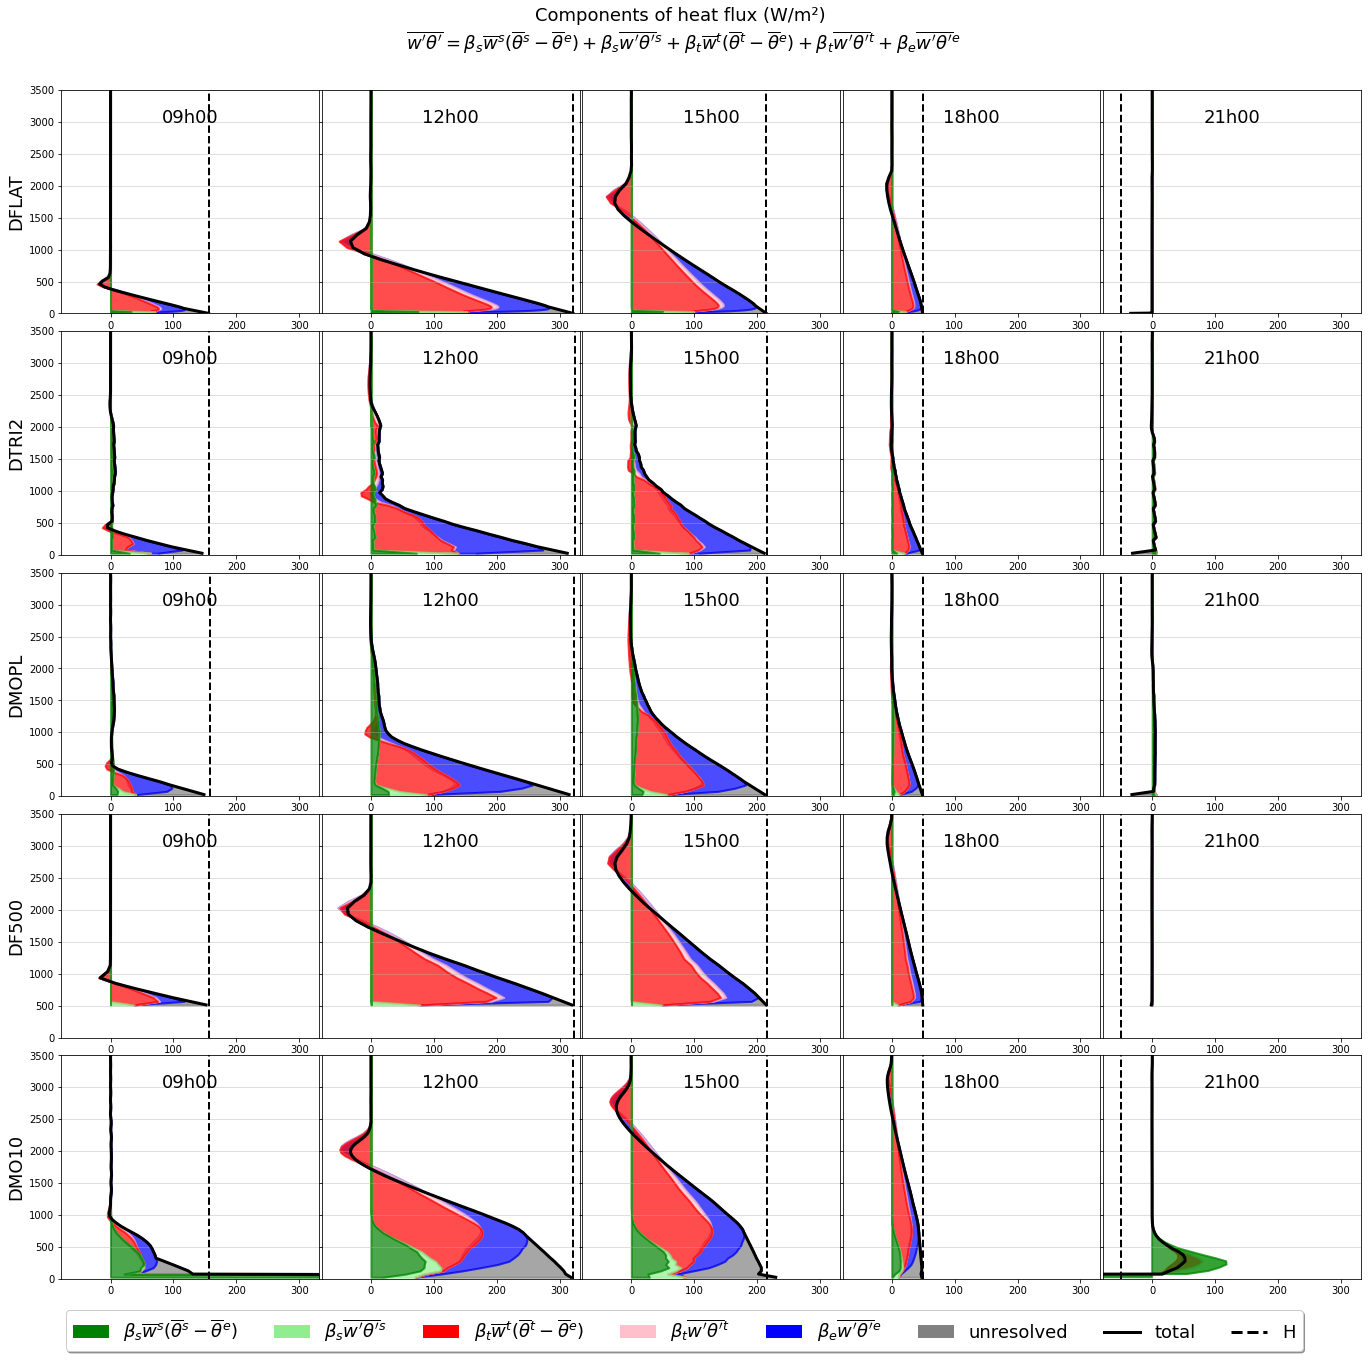

<Figure size 432x288 with 0 Axes>

In [17]:
draw_flux_simus(draw_thermal_groups = False,signed=False)

/tmp/ipykernel_35231/2814016480.py:89: RuntimeWarning: invalid value encountered in divide
  norm = Cp*fd('RHO')/fd('ALPHA') ; norm[fd('ALPHA')<0.0001]=np.nan


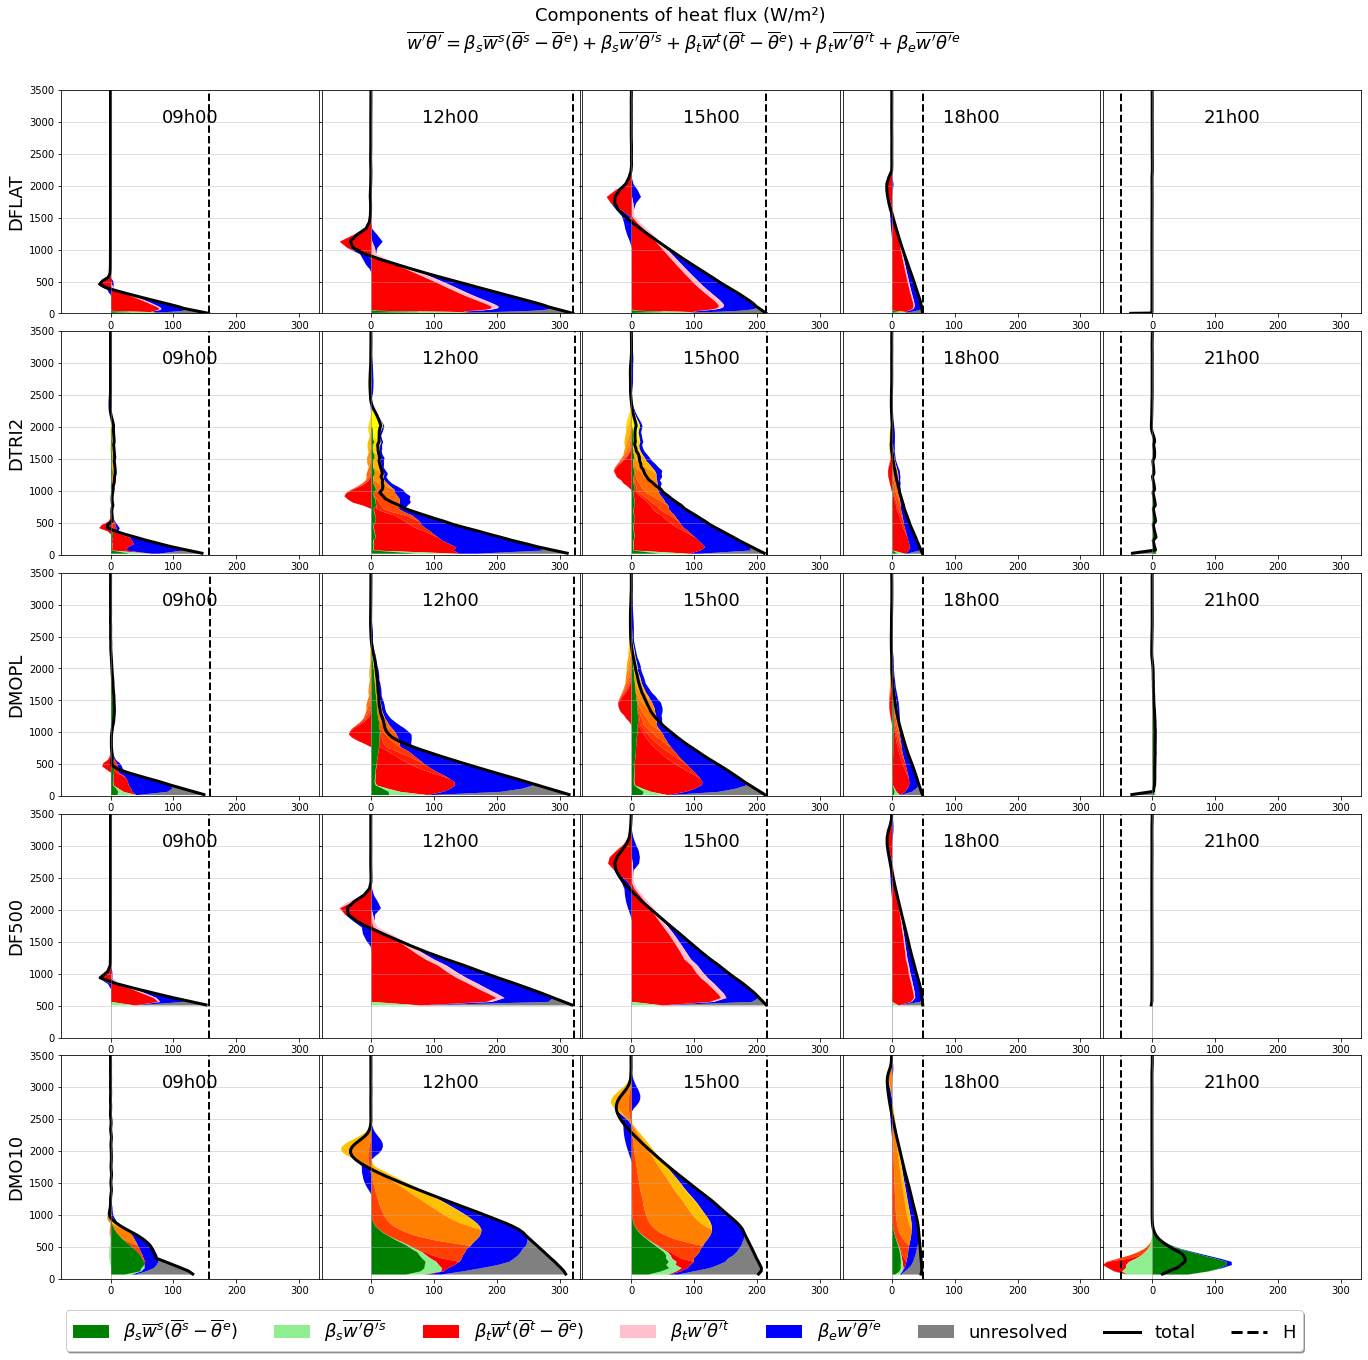

<Figure size 432x288 with 0 Axes>

In [29]:
draw_flux_simus(draw_thermal_groups = True,signed=True)